In [45]:
import numpy as np
import math
import random
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import Binarizer, MultiLabelBinarizer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

In [34]:
import actigamma as ag

In [35]:
# generate a dataset based on 100 bins from 0 to 2 MeV
MINENERGY = 0.0
MAXENERGY = 4e6
NBINS = 200
SPECTYPE = "gamma"

# setup the DB
db = ag.Decay2012Database()
grid = ag.EnergyGrid(bounds=ag.linspace(MINENERGY, MAXENERGY, NBINS+1))

In [200]:
# let's look at the distribution of number of lines per nuclide
# all nuclides with SPECTYPE lines
allradionuclides = db.allnuclidesoftype(spectype=SPECTYPE)

[ 1  1  8 ...  3 47  7]


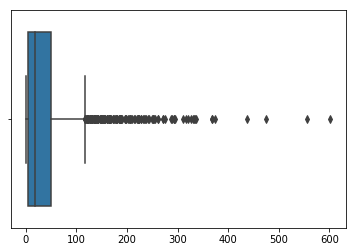

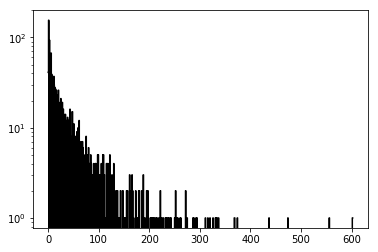

In [201]:
nucdata = {}
for nuc in allradionuclides:
    nucdata[nuc] = len(db.getenergies(nuc, spectype=SPECTYPE))
    
linecounts = np.array(list(nucdata.values()))
print(linecounts)

ax = sns.boxplot(x=linecounts)

f = plt.figure()
hist, bin_edges = np.histogram(linecounts, density=False, bins=1000)
X, Y = ag.getplotvalues(bin_edges, hist)
# plt.xlim(0,100)
plt.semilogy(X, Y, 'k')

In [61]:
# how many nuclides have more than 100 lines?
count = 0
for k, v in nucdata.items():
    if v > 50:
        count += 1
        
print(count)

429


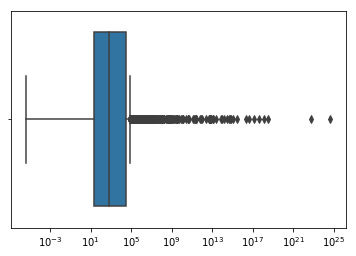

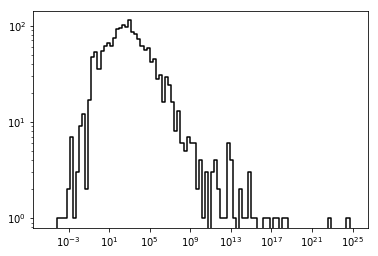

In [67]:
# look at the number of lines vs halflife
# if the halflife is less than 1 day or more than 10 years for example
# it is very likely this will not be seen
halflives = [ db.gethalflife(nuc) for nuc in radionuclides ]
ax = sns.boxplot(x=halflives)
plt.xscale("log")

f = plt.figure()
hist, bin_edges = np.histogram(halflives, density=False, bins=np.logspace(-5,25, 100))
X, Y = ag.getplotvalues(bin_edges, hist)
# plt.xlim(0,100)
plt.loglog(X, Y, 'k')

66076
2955


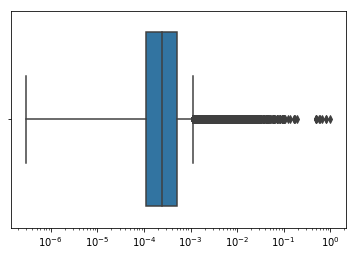

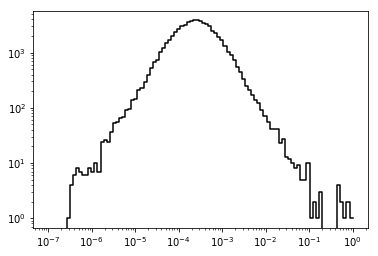

In [71]:
# look at the uncertainties on the line values
uncerts = []
nouncertcount = 0
for nuc in allradionuclides:
    line = db.getenergies(nuc, spectype=SPECTYPE)
    unc = db.getenergiesunc(nuc, spectype=SPECTYPE)
    for l,u in zip(line, unc):
        if u > 0:
            uncerts.append(u/l)
        else:
            nouncertcount += 1

            
print(len(uncerts))
print(nouncertcount)
ax = sns.boxplot(x=uncerts)
plt.xscale("log")

f = plt.figure()
hist, bin_edges = np.histogram(uncerts, density=False, bins=np.logspace(-7,0, 100))
X, Y = ag.getplotvalues(bin_edges, hist)
# plt.xlim(0,100)
plt.loglog(X, Y, 'k')

In [205]:
# pypact has a data dictionary, let's make sure we are not missing any
# nuclides
import pypact as pp

pypactnucs = []
for entry in pp.NUCLIDE_DICTIONARY:
    for isotope in entry['isotopes']:
        nuc = "{}{}".format(entry["element"], isotope)
        pypactnucs.append(nuc)
        
for radionuc in allradionuclides:
    nuctofind = radionuc
    # ignore states
    if not radionuc[-1].isnumeric():
        nuctofind = radionuc[:-1]
    
    # check we are not missing any
    if nuctofind not in pypactnucs:
        print(nuctofind)

In [285]:
# visualisation of chart of nuclides
import matplotlib.patches as patches


def nuclide_mapping(Z, A):
    """
        Return X, Y position where A is on X
        and Z is on Y.
        
        Note different to input!        
    """
    # split chart into four pieces 
    if Z <= 25:
        return int(A+15), int(Z+58)
    elif Z <= 60:
        return int(A-40), int(Z+8)
    elif Z <= 100:
        return int(A-125), int(Z-52)
    else:
        return int(A-178), int(Z-90)


def make_full_nuclide_chart(data_matrix=None):
    XSIZE = 140
    YSIZE = 90
    # define an empty matrix of size (90,140)
    # X and Y are inverted
    if data_matrix is None:
        data_matrix = np.zeros(shape=(YSIZE, XSIZE))
        data_matrix[:, :] = 0.0
        
    assert data_matrix.shape == (YSIZE, XSIZE)

    # make a chart of the nuclides
    fig, ax = plt.subplots(figsize=(20, 20))
    
    all_isotopes = []
    mZ = -1
    mA = -1
    for d in pp.NUCLIDE_DICTIONARY:
        for i in d['isotopes']:
            mZ = max(mZ, d['Z'])
            mA = max(mA, i)

            X, Y = nuclide_mapping(d['Z'], i)
            all_isotopes.append((X,Y))
            rect = patches.Rectangle((X-0.5,Y-0.5), 1, 1, linewidth=1, edgecolor='k',facecolor='none')
            ax.add_patch(rect)

    # set everything that is not in the nuclide chart to grey
    # for 'Set1' this is 8
    cm = 'Set1'
    for x in range(XSIZE):
        for y in range(YSIZE):
            if (x, y) not in all_isotopes:
                data_matrix[y, x] = 8
            
    im = plt.imshow(data_matrix, cmap=cm)
#     ax.invert_yaxis()
    ax.axis('off')
    plt.xlabel("A", fontsize=16)
    plt.ylabel("Z", fontsize=16)
    plt.xlim([0, XSIZE])
    plt.ylim([0, YSIZE])
#     fig.colorbar(im, cax = fig.add_axes([0.91, 0.2, 0.03, 0.6]))
    
    return fig, ax

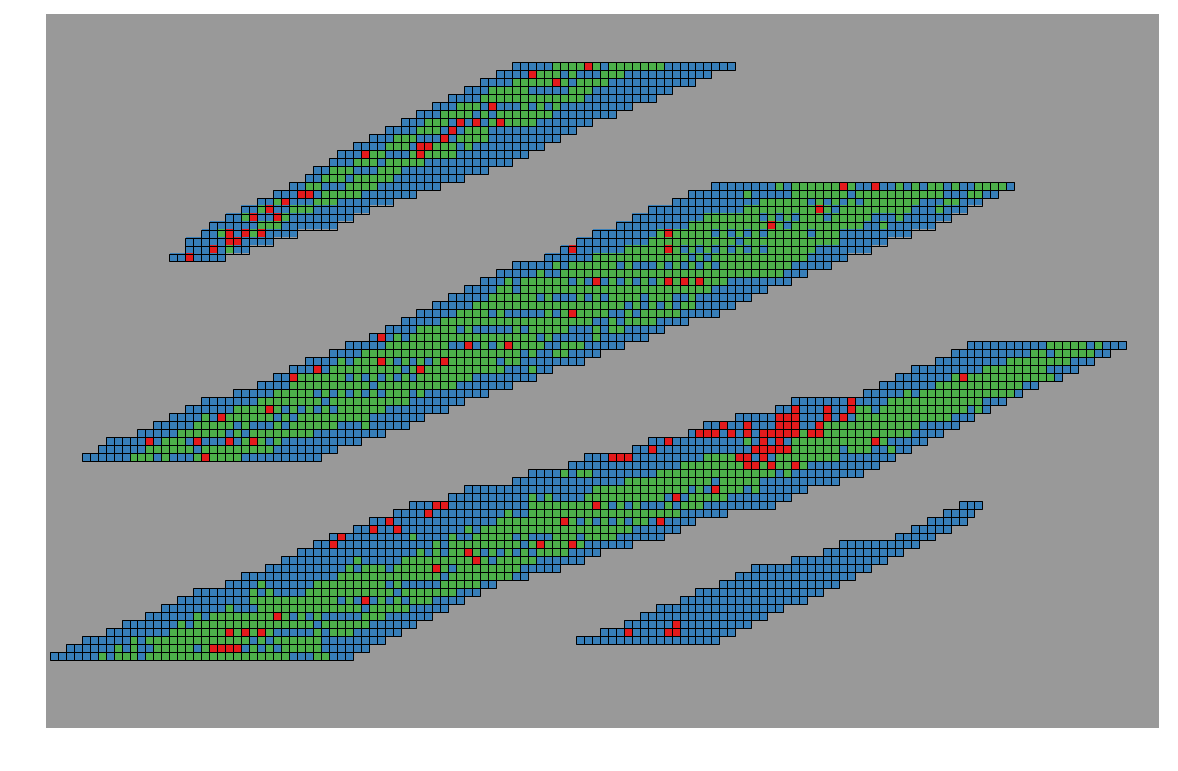

In [290]:
# for Set1 1 == blue - all nuclides that are either stable or no data in database
data_matrix = np.ones(shape=(140, 90))

# show all radioisotopes
# for Set1 0 == red - all nuclides that are unstable and exist in database
for nuc in db.allnuclides:
    z, a, _ = pp.library.nuclidelib.get_zai_props(db.getzai(nuc))
    x, y = nuclide_mapping(z, a)
    data_matrix[x, y] = 0
    
# show all radioisotopes for that spectype
# for Set1 2 == green - all nuclides that are unstable and have gamma lines in database
for nuc in allradionuclides:
    z, a, _ = pp.library.nuclidelib.get_zai_props(db.getzai(nuc))
    x, y = nuclide_mapping(z, a)
    data_matrix[x, y] = 2

fig1, ax1 = make_full_nuclide_chart(data_matrix=data_matrix.transpose())

In [4]:
class RandomLineAggregator(ag.LineAggregator):
    """
        Randomly vary the line energies by their uncertainty

        TODO: randomly remove lines with low intensity or related to their intensity
    """
    def _findlines(self, inventory: ag.UnstablesInventory, *args, spectype: str="gamma", **kwargs):
        lines = []
        values = []

        nrofsigma = 1
        if 'nrofsigma' in kwargs:
            nrofsigma = kwargs['nrofsigma']

        for zai, activity in inventory:
            name = self.db.getname(zai)
            # check it exists in database
            if name not in self.db:
                raise ag.UnknownOrUnstableNuclideException(
                    "{} not in database - maybe too exotic or is it stable?".format(zai))

            # check that data exists for that decay type
            if spectype not in self.db.gettypes(name):
                raise ag.NoDataException(
                    "{} does not have {} decay mode".format(name, spectype))

            energies = self.db.getenergies(name, spectype=spectype)
            energyunc = self.db.getenergiesunc(name, spectype=spectype)
            intensities = self.db.getintensities(name, spectype=spectype)*activity

            newenergies = []
            for emean, eunc in zip(energies, energyunc):
                newenergies.append(np.random.normal(emean, eunc*nrofsigma))
            lines.extend(np.array(newenergies))
            values.extend(intensities)

        return lines, values

In [5]:
# just take 10 nuclides at random
radionuclides = allradionuclides
random.shuffle(allradionuclides)
print(len(allradionuclides))

1750


In [6]:
# create a line aggregator based on randomly varying the line energy
lc = RandomLineAggregator(db, grid)

In [7]:
def get_random_inventory(maxnuclides=5):
    # randomly pick between 1 and maxnuclides to generate data
    nrofnuclides = random.randrange(1, maxnuclides+1)
    # pick nrofnuclides - must be unique 
    nuclides = []
    indices = []
    while len(nuclides) < nrofnuclides:
        indx = random.randrange(maxnuclides)
        nuclide = allradionuclides[indx]
        if nuclide not in nuclides:
            nuclides.append(nuclide)
            indices.append(indx)

    # random activity between 1e18 and 1e21 atoms
    inv = ag.UnstablesInventory(data=[(db.getzai(n),
        ag.activity_from_atoms(db, n, np.random.uniform(low=1e18, high=1e21))) \
            for n in nuclides])
    hist, _ = lc(inv, spectype=SPECTYPE, nrofsigma=3)
    return hist, indices, inv,

In [8]:
def plot_inventory(hist, inv=None, newfig=True, colour='k', logy=True, **kwargs):
    X, Y = ag.getplotvalues(grid.bounds, hist)
    if newfig:
        fig = plt.figure(figsize=(12,7))
    plt.plot(X, Y, colour)
    plt.xlabel("Energy ({})".format(grid.units), fontsize=18)
    plt.ylabel("{} per unit time (s-1)".format(SPECTYPE), fontsize=18)
    if logy:
        plt.yscale('log')
#     plt.show()
    if inv:
        print([db.getname(zai) for zai in inv.zais])
        print([act for act in inv.activities])

['Rn221', 'I134', 'Hg197m', 'Mo105', 'Ar35']
[1.5181028617948995e+17, 1.7406162249871696e+17, 1500580040784597.2, 1.6366929561438765e+19, 1.542545718269582e+20]


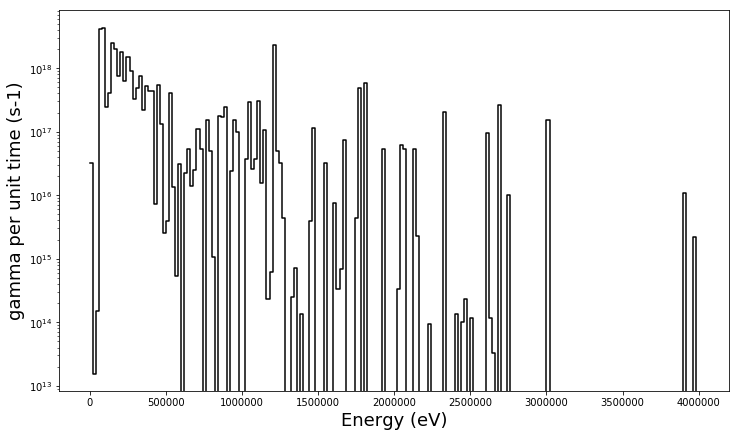

In [9]:
hist, _, inv = get_random_inventory()
plot_inventory(hist, inv)

In [21]:
# make a dataset based on randomly generated variations of sample data
NSAMPLES = 1000
datasetX, datasetY = [], []
for _ in range(NSAMPLES):
    hist, indices, _ = get_random_inventory(maxnuclides=10)
    datasetX.append(np.array(hist))
    datasetY.append(indices)

In [11]:
# let's look at scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
    
# fig, ax1 = plt.subplots(figsize=(12,7))
        
# X, Y = ag.getplotvalues(grid.bounds, datasetX[0])
# ax1.plot(X, Y, 'k')
# ax1.set_xlabel("Energy ({})".format(grid.units), fontsize=18)
# ax1.set_ylabel("{} per unit time (s-1)".format(SPECTYPE), fontsize=18)
# ax1.set_yscale('log')

# # convert to log values then min max scale
# data_min = np.nanmin(datasetX, axis=1)
# data_max = np.nanmax(datasetX, axis=1)
# for i, data in enumerate(datasetX):
#     datasetX[i] = (np.log(data+1) - data_min[i]) / (math.log(data_max[i]) - data_min[i])
# # we need to scale values from log to [0,1] -> how best to do this?
# # datasetX = MinMaxScaler().fit_transform(datasetX)

# ax2 = ax1.twinx()
# ax2.set_ylabel("Scaled")
# X, Y = ag.getplotvalues(grid.bounds, datasetX[0])
# ax2.plot(X, Y, 'r')

In [22]:
# ignore scaling altogether and just have binary values (0=no lines, 1=lines present in bin)
datasetX = Binarizer().transform(datasetX)
datasetY = MultiLabelBinarizer().fit_transform(datasetY)

In [23]:
X_train, X_test, y_train, y_test = \
    train_test_split(datasetX, datasetY, test_size=.4, random_state=42)

In [24]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 1, 0, 0]])

In [25]:
classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, max_features='auto', verbose=False))

In [26]:
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print(score)

0.4825


In [27]:
# plot + predict
def plot_and_predict(indices):
    testnuclides = [radionuclides[i] for i in indices]
    inv = ag.UnstablesInventory(data=[(db.getzai(n), 
                                       ag.activity_from_atoms(db, 
                                                              n, 
                                                              np.random.uniform(low=1e18, high=1e21))) 
                                      for n in testnuclides])

    lc = ag.LineAggregator(db, grid)
    hist, _ = lc(inv, spectype=SPECTYPE)
    prediction = classifier.predict([[1 if bin > 0 else 0 for bin in hist ]])
    print([i for i, n in enumerate(prediction[0]) if n > 0])
    plot_inventory(hist)

[1]


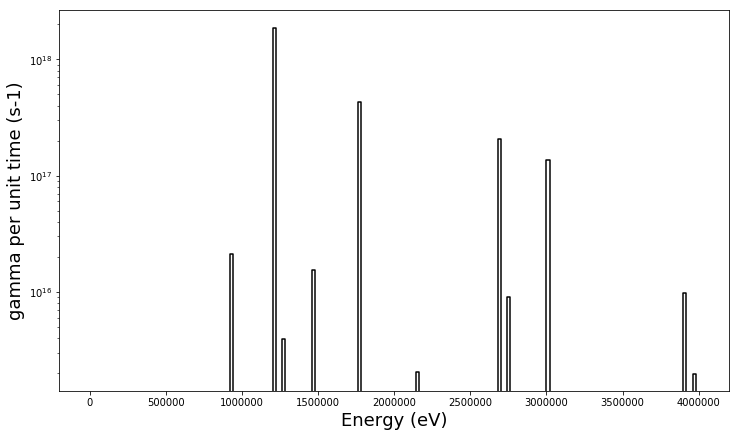

In [28]:
plot_and_predict([1])

[1, 2, 3]


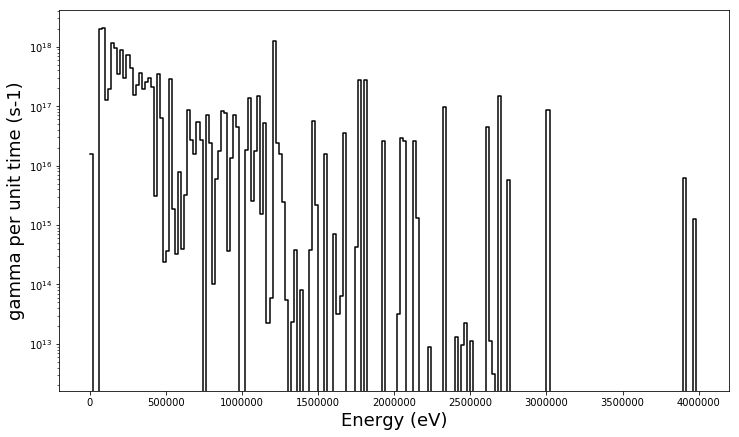

In [30]:
plot_and_predict([0, 1, 2, 3, 10])